# Energy Insecurity in the US: regression prediction


### Table of Contents
I. [Dependent vb selection](#background)<br>
II. [Data Cleaning](#load) <br>
III. [Regression: Forecasting and Prediction Modeling](#reg) <br>
IV. [Apply best regression model](#prediction_reg)<br>

In [19]:
#!pip install importlib-resources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import geopandas as gpd
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
import math

from sklearn.model_selection import train_test_split
import timeit

warnings.filterwarnings('ignore')

In [20]:
import recs_EDA
import regression_recs_sample_weights as reg
#import new_bootstrapped_quant as bootstrap

---

## Dependent vb selection <a id='background'></a>


Regression methods on `TOTALBTU` and `EUI`.

##### Select Dependent Variable

In [21]:
# If effiency = True, heating EUI predicted, otherwise selet endogeneous variable 
efficiency = True
y_name = "TOTALBTU"# BTUEL, BTUNG TOTALBTU 'BTUOF', 

---

## Data Cleaning  <a id='load'></a>
We will walk through the data cleaning of RECS for out *prediction problem*. 

##### 1. Import RECS


In [25]:
path = '/global/scratch/users/cristina_crespo/p1_data/'
RECS_raw = pd.read_csv(path +'RECS/recs2020_public_v5.csv')
RECS_raw.shape

(18496, 789)

In [26]:
RECS_raw.NWEIGHT.sum() 

123529025.00075468

##### 2. Set up results table, set up y, X variable

Deal with nominal v ordinal variables, normalize & input missing data

In [27]:
def clean_vbs(RECS_raw):
    
    X_sub, Y, RECS_norm_param = recs_EDA.vb_transform(RECS_raw) 
    return X_sub, Y

In [28]:
def prep_eui(RECS_raw, X_sub, surface, e_use):
    
    #construct Y variable
    y_name = "EUI_"+e_use
    
    #Change cases with surface value of 0 to 0 energy use
    RECS_raw[e_use]=np.where(RECS_raw[surface]==0, 0, RECS_raw[e_use])
    RECS_raw[surface]=np.where(RECS_raw[surface]==0, 1, RECS_raw[surface]) #0 dvided by 1 will be 0, to solve indetermination
    
    #calc y
    y=RECS_raw.loc[:,e_use].reset_index(drop = True).div(RECS_raw.loc[:,surface].reset_index(drop = True)) 

    
    return X_sub, y, y_name

In [29]:
#Set up summary dataframe to compare models
summary_table = pd.DataFrame(columns = ['Model','R2', 'MSE', 'RMSE','MAE', 'MAPE']) 

#if efficiency caluclated, prepare dep variable
if y_name == "TOTALBTU" and efficiency == True:
    X_sub, Y = clean_vbs(RECS_raw)
    #clean recs
    surface = 'TOTHSQFT' #TOTHSQFT, TOTCSQFT
    e_use = 'TOTALBTUSPH' #TOTALBTUSPH, BTUELCOL #Calibrated electricity usage for space cooling (central air conditioning, individual units, and evaporative coolers), in thousand Btu, 2020 (dont include BTUELAHUCOL #Calibrated electricity usage furnace fans used for cooling  in thousand Btu, 2020
    X_sub, y, y_name = prep_eui(RECS_raw, X_sub,surface, e_use )

else: 
    #clean recs
    X_sub, Y = clean_vbs(RECS_raw)
    y=Y[y_name].reset_index(drop = True) 

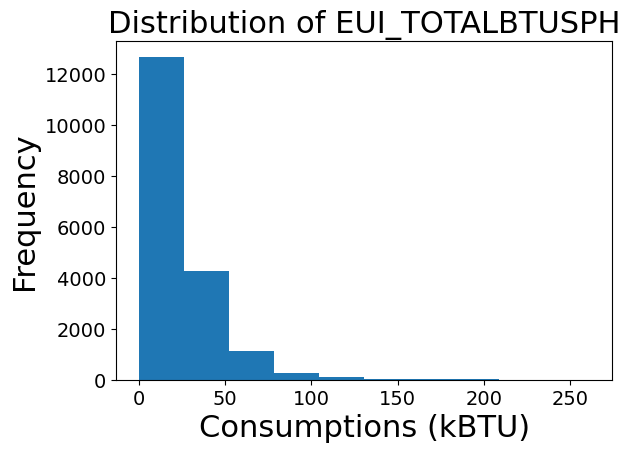

In [30]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(y)

ax.set_title("Distribution of "+y_name, fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("Consumptions (kBTU)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

---

## Regression: Forecasting and Prediction Modeling<a id='reg'></a>



##### 1. Create splits for bootstraps

The following cell will be used for all regression models to create the cross validated test/train splits in the data (conserving the same random state and proportion throughout the model comparisons).

In [10]:
#divide test/train
test_prop = 0.2

#set up dep and indep vbs
#X = RECS_raw[['HDD30YR_PUB','CDD30YR_PUB','TYPEHUQ','KOWNRENT','YEARMADERANGE','BEDROOMS', 'NWEIGHT']]
#y = RECS_raw.TOTALBTU

boots = False
if boots == True:
    #save bootstrap proportions
    boot_samples = pd.DataFrame(columns=['boot_num', 'len_Xtrain','prop_18k', 'prop_126M'])
    
    #drop weights
    #drop weight column
    weights = X_sub.NWEIGHT
    X =  X_sub.drop('NWEIGHT', axis = 1)
                   
    #split with bootstraps
    n = round(math.sqrt(len(X)))
    for b in range(n):
        
        X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X,y, weights, test_size =test_prop, random_state=b)

        boot_samples.loc[b, 'boot_num'] = b
        boot_samples.loc[b, 'len_Xtrain'] = len(X_train)
        boot_samples.loc[b, 'prop_18k'] = len(X_train)/len(X_sub)
        boot_samples.loc[b, 'prop_126M'] = X_train.NWEIGHT.sum()/X_sub.NWEIGHT.sum()
        #drop weight column
        X = X_sub.drop(columns = ['NWEIGHT'], inplace = True)
else:
    b = 0
    #drop weight column
    weights = X_sub.NWEIGHT
    X = X_sub.drop('NWEIGHT', axis = 1)
    X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X,y, weights, test_size =test_prop, random_state=b)


apply_weights = True
if apply_weights == True:
    pass
else:
    sw_train = np.ones(len(sw_train))
    sw_test = np.ones(len(sw_test))
         
    

In [11]:
#boot_samples.prop_126M.mean()
#boot_samples.prop_126M.hist()

##### 2. Feature engineering


In [12]:
#Feature Engineering 
feature_engineer = True

n = len(X.columns)

if feature_engineer == True:
    interactions = 1+0.5*n+0.5*n**2 - 1 #intercept
    
    poly = PolynomialFeatures(interaction_only=True,include_bias = False)
    X_train_eng = poly.fit_transform(X_train)
    X_test_eng = poly.fit_transform(X_test)
    
    X_train = pd.DataFrame(X_train_eng, columns = poly.get_feature_names_out(X_train.columns))
    X_test = pd.DataFrame(X_test_eng, columns = poly.get_feature_names_out(X_test.columns))
else:
    interactions = n


---

## Regression: Apply best model <a id='prediction_reg'></a>

##### Regression on:

- EUI_heating 
Boosting 

- EUI_cooling
Elastic Net 

- BFUOF
Lasso 

- TOTALBTU
ANN 

- BTUNG
ANN 

- BTUEL
ANN 

In [13]:
df_acs_raw = pd.read_csv(path+'out_final/ct_enhanced_model_application_final.csv')
#this file is generated by 2_prep_us_ct_variables.ipynb
df_acs = df_acs_raw.drop(columns = ['Unnamed: 0', 'total_population', 'state', 'county', 'tract'])

In [14]:
len(df_acs)

82907

In [15]:
#fill in missing value
df_acs.loc[df_acs['Average year built'].isna(), 'Average year built'] = df_acs['Average year built'].median()

In [16]:
df_acs.isna().sum().sum()

0

In [17]:
def feature_eng(df_acs):
    
    poly = PolynomialFeatures(interaction_only=True,include_bias = False)
    X_acs_eng = poly.fit_transform(df_acs)
        
    df_acs = pd.DataFrame(X_acs_eng, columns = poly.get_feature_names_out(df_acs.columns))
    
    return df_acs

In [18]:
def align_features(df_acs, X_train):
    """
    Aligns df_acs to have the same column names, order, and data types as X_train.
    
    Parameters:
    df_acs (pd.DataFrame): The new data to apply the model to.
    X_train (pd.DataFrame): The training data used to fit the model.
    
    Returns:
    pd.DataFrame: Aligned df_acs with column names, order, and dtypes matching X_train.
    """

    # Rename and reorder columns to match X_train
    df_acs.columns = X_train.columns
    df_acs = df_acs[X_train.columns]

    # Convert data types to match
    for col in X_train.columns:
        expected_dtype = X_train[col].dtype
        actual_dtype = df_acs[col].dtype
        if expected_dtype != actual_dtype:
            df_acs[col] = df_acs[col].astype(expected_dtype)

    # Final assertions to confirm match
    assert list(df_acs.columns) == list(X_train.columns), "Column names do not match"
    assert all(df_acs.dtypes == X_train.dtypes), "Column types do not match"

    return df_acs

In [19]:
#Add feature eng
if feature_engineer == True:
    df_acs = feature_eng(df_acs)
    df_acs = align_features(df_acs, X_train)
else:
    pass

In [ ]:
if y_name == "BTUEL":
    print('BTUEL')
    pred_name = y_name+'_pred'
    
    #gen model
    clf, score_sub, summary_table = reg.ANN_fit(X_train, y_train, X_test, y_test, sw_train, sw_test, summary_table)
    #apply model
    y_pred= clf.predict(df_acs)
    df_acs[pred_name]=y_pred

elif y_name == "BTUNG":
    print('BTUNG')
    pred_name = y_name+'_pred'
    
    #gen model
    clf, score_sub, summary_table = reg.ANN_fit(X_train, y_train, X_test, y_test, sw_train, sw_test, summary_table)
    #apply model
    y_pred= clf.predict(df_acs)
    df_acs[pred_name]=y_pred
    
elif y_name == "BTUOF":
    print('BTUOF')
    pred_name = y_name+'_pred'
    
    
    #gen model
    Models = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet'] # list of models
    mod = dict.fromkeys(Models) #save models here for prediction

    for Model, i in zip(Models, np.arange(len(Models))):
        summary_table, mod[Models[i]]  = reg.regularization_fit(Model, X_train, y_train, X_test, y_test, sw_train, sw_test, summary_table, efficiency)
    
    #apply model
    y_pred= mod['Lasso'].predict(df_acs)
    df_acs[pred_name]=y_pred
    
elif y_name == "TOTALBTU":
    
    print('TOTALBTU')
    pred_name = y_name+'_pred'
    
    
    #gen model
    clf, score_sub, summary_table = reg.ANN_fit(X_train, y_train, X_test, y_test, sw_train, sw_test, summary_table)
    #apply model
    y_pred= clf.predict(df_acs)
    df_acs[pred_name]=y_pred
    
elif y_name == "EUI_TOTALBTUSPH":
    print('EUI_TOTALBTUSPH')
    pred_name = 'HEAT_EUI_pred'
    
    
    #gen model
    bag, rf, gb, ab, summary_table = reg.ensemble_fit(X_train, y_train,  X_test, y_test, sw_train, sw_test, summary_table)
    
    #apply model
    y_pred= gb.predict(df_acs)
    df_acs[pred_name]=y_pred

elif y_name == "EUI_BTUELCOL":
    print('EUI_BTUELCOL')
    pred_name = 'COOL_EUI_pred'
    
    #gen model
    Models = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet'] # list of models
    mod = dict.fromkeys(Models) #save models here for prediction

    for Model, i in zip(Models, np.arange(len(Models))):
        summary_table, mod[Models[i]]  = reg.regularization_fit(Model, X_train, y_train, X_test, y_test, sw_train, sw_test, summary_table, efficiency)
    
    #apply model
    y_pred= mod['ElasticNet'].predict(df_acs)
    df_acs[pred_name]=y_pred

else:
    pass
    

EUI_TOTALBTUSPH


In [ ]:
print('Done')

In [ ]:
df_acs_final = df_acs.join(df_acs_raw[['state', 'county', 'tract']], how='inner') 
df_acs_final[['state', 'county', 'tract', pred_name]].to_csv(path+'out_final/metric_predictions/'+y_name+'_predict_ct.csv')  